In [1]:
# Code for analyzing NFL big data bowl data (probably with Celia!!!)

In [221]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import nflDataFunctions as nfldf

pd.set_option('display.max_rows', 50)

In [7]:
games, players, plays, pffData = nfldf.loadData()
weekData = nfldf.loadWeek()

In [88]:
playWeek = nfldf.playWeek(games, plays)

In [218]:
# Code to identify target Receiver
receiverName, descName, receiverDistance, receiverNextClosestDistance, qbNflId = \
nfldf.identifyTargetReceiver(weekData[0],plays,playWeek,weekId=1)

In [220]:
# for rname,dname in zip(receiverName, descName): print(f"Receiver: {rname}, description: {dname}")

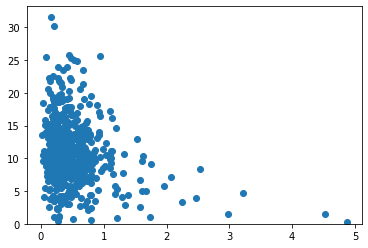

In [232]:
plt.scatter(receiverDistance, receiverNextClosestDistance-receiverDistance)
# plt.xlim(0, np.maximum(np.max(receiverDistance), np.max(receiverNextClosestDistance)))
plt.ylim(0)#, np.maximum(np.max(receiverDistance), np.max(receiverNextClosestDistance)))
plt.show()